<a href="https://colab.research.google.com/github/IamLucifer0312/Furniture-Recognition-CNN/blob/main/Task1_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the Furniture dataset, there are 06 categories: beds  - 6578 images; chairs  - 22053 images;
dressers - 7871 images; lamps  - 32402 images; sofas  - 4080 images; tables - 17100 images,
with total of 90084 images.

For every category, there are 17 interior styles:
(a) Asian; (b) Beach; (c) Contemp; (d) Craftsman; (e) Eclectic; (f) Farmhouse; (g) Industrial
(h) Media; (i) Midcentury; (j) Modern; (k) Rustic; (l) Scandinavian; (m) Southwestern
(n) Traditional; (o) Transitional; (p) Tropical and (q) Victorian

# **Task 1:** Classify images according to furniture category (beds; chairs; dressers; lamps; sofas; tables)

## This is Part 2



### First, mount the Google Drive to start downloading necessary files




In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Download the original dataset

In [2]:
import gdown

# Google Drive file ID (from the shared link)
file_id = "1h2SIWZZUESO6xygzF4iMkK-tVc4mZ27M"
file_name = "Furniture_Data.zip"
file_path = "/content/" + file_name

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name, quiet=False)
print(f"Downloaded: {file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1h2SIWZZUESO6xygzF4iMkK-tVc4mZ27M
From (redirected): https://drive.google.com/uc?id=1h2SIWZZUESO6xygzF4iMkK-tVc4mZ27M&confirm=t&uuid=e470ea23-c52b-472f-b2a3-bfefd742eff0
To: /content/Furniture_Data.zip
100%|██████████| 2.49G/2.49G [00:22<00:00, 110MB/s]

Downloaded: /content/Furniture_Data.zip


### Download the Extra Dataset.
Since the model in Part 1 proves that the model trained on the original dataset performs badly on unseen images with different background patterns, I have collected more data from Kaggle and ImagesCV to improve the performance.

The extra dataset provides data for only all classes, excluding the lamps class, which originally has a huge number of images already.

Also, this extra dataset is only used in the first task. Therefore, it has no style classification.

In [3]:
import gdown

# Google Drive file ID (from the shared link)
extra_file_id = "18mbYvEBOtNTaP9RlirxAYShGaNVgvgj8"
extra_file_name = "ExtraData.zip"
extra_file_path = "/content/" + extra_file_name
# Download the file
gdown.download(f"https://drive.google.com/uc?id={extra_file_id}", extra_file_name, quiet=False)
print(f"Downloaded: {file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1YMg7EsQumAog9iUqzKeP2hiSVWqAS1EI
From (redirected): https://drive.google.com/uc?id=1YMg7EsQumAog9iUqzKeP2hiSVWqAS1EI&confirm=t&uuid=5ce26c9d-c3ad-4331-9542-3a9d1cce5caa
To: /content/ExtraData.zip
100%|██████████| 99.4M/99.4M [00:00<00:00, 157MB/s]

Downloaded: /content/Furniture_Data.zip


### Now upzip the two dataset

In [4]:
!unzip -q $file_path -d /content/extracted_folder


In [5]:
!unzip -q $extra_file_path -d /content/extracted_extra_data

### Define the categories


In [6]:
categories = ['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']

### The original dataset is in the format of nested folder:
     Folder:
     -- Category 1:
        -- Style 1
        -- Style 2
        ...
     ...
### So now we need to reconstruct it to only containing category subfolders, which is more suitable for this task.

In [7]:
import os
import shutil

# Define paths
original_dataset_path = '/content/extracted_folder/Furniture_Data'  # Path to your original dataset
new_dataset_path = 'Task1_Data'          # Path to the new flattened dataset

# Create the new folder structure
for category in categories:
    os.makedirs(os.path.join(new_dataset_path, category), exist_ok=True)

# Copy images to the new structure
for category in categories:
    category_path = os.path.join(original_dataset_path, category)
    for style in os.listdir(category_path):
        style_path = os.path.join(category_path, style)
        if os.path.isdir(style_path):
          for image in os.listdir(style_path):
              src = os.path.join(style_path, image)
              dst = os.path.join(new_dataset_path, category, image)
              shutil.copy(src, dst)

### Now plot the data distribution among classes

['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']


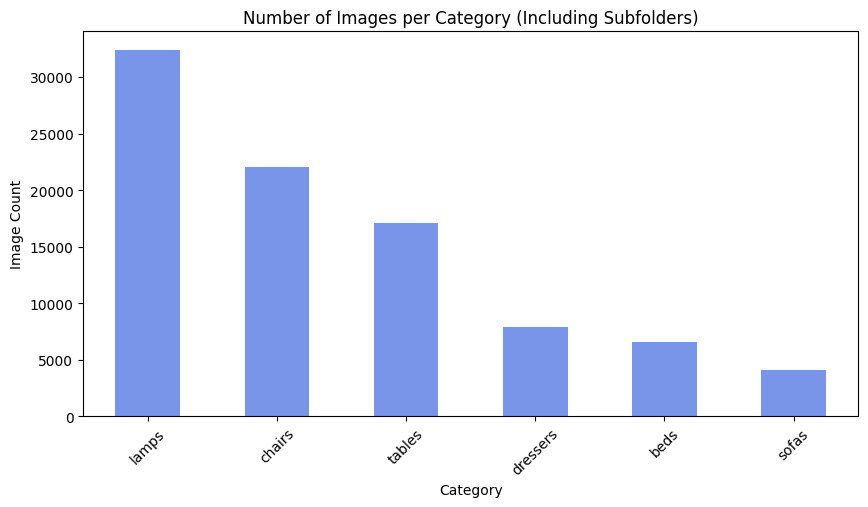

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

dataset_path = "/content/" + new_dataset_path

def count_images(category_path):
    """Counts all image files within a category, including subfolders."""
    count = 0
    for root, _, files in os.walk(category_path):
        count += sum(1 for file in files if file.lower().endswith(('.jpg', '.png', '.jpeg')))
    return count

print(categories)
# Count images for each category
category_counts = {category: count_images(os.path.join(dataset_path, category)) for category in categories}

# Convert to DataFrame
df = pd.DataFrame.from_dict(category_counts, orient="index", columns=["Image Count"])
df.sort_values("Image Count", ascending=False, inplace=True)

# Plot category distribution
plt.figure(figsize=(10, 5))
df["Image Count"].plot(kind="bar", color="royalblue", alpha=0.7)
plt.title("Number of Images per Category (Including Subfolders)")
plt.xlabel("Category")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.show()


As we can see, the dataset is significantly imbalance, so we need to handle that with some techniques.

### First, resize all images in the extra dataset

In [9]:
import cv2

extra_dataset_path = "/content/extracted_extra_data/ExtraData/"
extra_categories = ['beds', 'chairs', 'dressers', 'sofas', 'tables']

# Function to resize image in place
def resize_image(image_path, size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Skipping {image_path}, could not be read.")
        return False  # Indicate failure

    resized_img = cv2.resize(img, size)
    cv2.imwrite(image_path, resized_img)  # Overwrite original image
    return True  # Indicate success

resized_count = 0

for category in categories:
    category_path = os.path.join(extra_dataset_path, category)

    if os.path.exists(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Resize image in place
            if resize_image(img_path):
                resized_count += 1
                print(f"Resized: {img_path}")

print(f"Total resized images: {resized_count}")


Resized: /content/extracted_extra_data/ExtraData/beds/00000241.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000626.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000732.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000970.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000288.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000548.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000709.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000180.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000280.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000333.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000420.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000776.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000170.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000314.jpg
Resized: /content/extracted_extra_data/ExtraData/beds/00000256

### Now plot some examples to see how good the resizing is

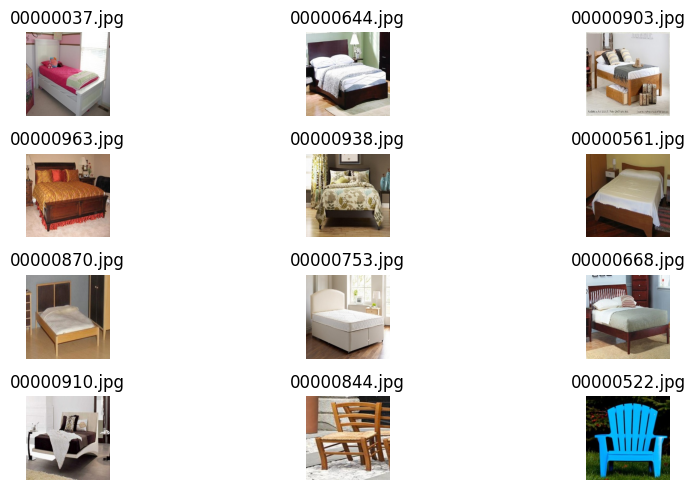

In [10]:
import random

# Collect a few images to display
sample_images = []
for category in categories:
    category_path = os.path.join(extra_dataset_path, category)

    if os.path.exists(category_path):
        image_files = [os.path.join(category_path, img) for img in os.listdir(category_path)]
        random.shuffle(image_files)  # Shuffle to get random images
        sample_images.extend(image_files[:10])  # Select up to 2 images per category

# Plot images
plt.figure(figsize=(10, 5))
for i, img_path in enumerate(sample_images[:12]):  # Limit to 6 images
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        plt.subplot(4, 3, i + 1)  # 4 rows, 3 columns
        plt.imshow(img)
        plt.title(os.path.basename(img_path))  # Show file name
        plt.axis('off')

plt.tight_layout()
plt.show()

### Next, move all extra images to its corresponding category folder in the original dataset

In [11]:
import cv2
deleted_count = 0  # Initialize deleted count

for category in extra_categories:
    category_path = os.path.join(dataset_path, category)
    extra_category_path = os.path.join(extra_dataset_path, category)

    if os.path.exists(extra_category_path):
        os.makedirs(category_path, exist_ok=True)  # Ensure category folder exists

        for img_name in os.listdir(extra_category_path):
            img_path = os.path.join(extra_category_path, img_name)
            dest_path = os.path.join(category_path, img_name)

            # Copy the image without resizing
            shutil.copy(img_path, dest_path)
            print(f"Copied: {img_path} -> {dest_path}")

            os.remove(img_path)  # Delete after copying
            deleted_count += 1

print(f"Total moved images: {deleted_count}")


Copied: /content/extracted_extra_data/ExtraData/beds/00000241.jpg -> /content/Task1_Data/beds/00000241.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000626.jpg -> /content/Task1_Data/beds/00000626.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000732.jpg -> /content/Task1_Data/beds/00000732.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000970.jpg -> /content/Task1_Data/beds/00000970.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000288.jpg -> /content/Task1_Data/beds/00000288.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000548.jpg -> /content/Task1_Data/beds/00000548.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000709.jpg -> /content/Task1_Data/beds/00000709.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000180.jpg -> /content/Task1_Data/beds/00000180.jpg
Copied: /content/extracted_extra_data/ExtraData/beds/00000280.jpg -> /content/Task1_Data/beds/00000280.jpg
Copied: /content/extracted_extra_data

### Plot the data distribution again

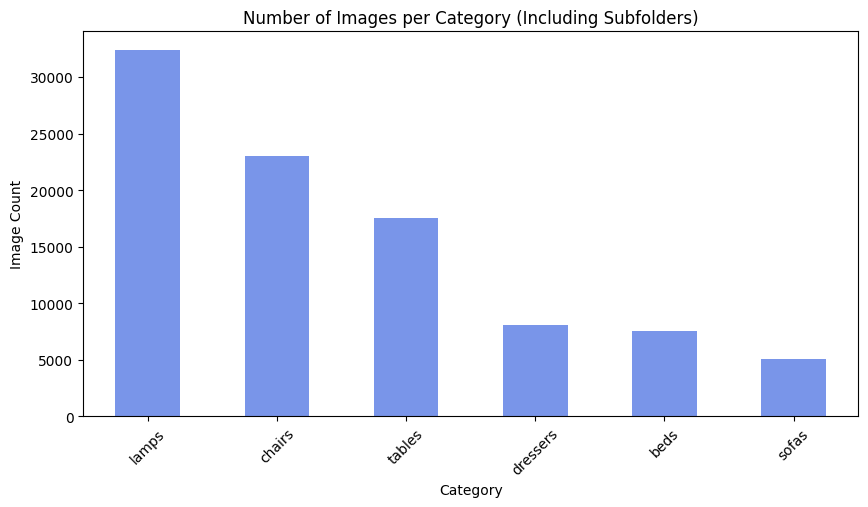

In [12]:
def count_images(category_path):
    """Counts all image files within a category, including subfolders."""
    count = 0
    for root, _, files in os.walk(category_path):
        count += sum(1 for file in files if file.lower().endswith(('.jpg', '.png', '.jpeg')))
    return count

# Count images for each category
category_counts = {category: count_images(os.path.join(dataset_path, category)) for category in categories}

# Convert to DataFrame
df = pd.DataFrame.from_dict(category_counts, orient="index", columns=["Image Count"])
df.sort_values("Image Count", ascending=False, inplace=True)

# Plot category distribution
plt.figure(figsize=(10, 5))
df["Image Count"].plot(kind="bar", color="royalblue", alpha=0.7)
plt.title("Number of Images per Category (Including Subfolders)")
plt.xlabel("Category")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.show()


As shown, the extra dataset added a small number to 5 later classes, but the dataset is still very imbalance.

### Now we remove all duplicated images in all classes using hash. This ensures the variety of the dataset before train-val-test split.

In [13]:
import hashlib
from PIL import Image
import cv2
import random

# Function to compute image hash
def get_image_hash(image_path):
    """Generate an MD5 hash for an image file."""
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Store unique images and duplicates
hashes = {}
deleted_count = 0

# Traverse categories and subfolders
for category in categories:
    category_path = os.path.join(dataset_path, category)

    if os.path.exists(category_path):
      image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
      for img_name in image_files:
          img_path = os.path.join(category_path, img_name)
          img_hash = get_image_hash(img_path)

          if img_hash in hashes:
              os.remove(img_path)  # Delete duplicate image
              deleted_count += 1
              print(f"Deleted: {img_path}")
          else:
              hashes[img_hash] = img_path  # Store first occurrence


# Report results
print(f"\n Removed {deleted_count} duplicate images.")

Deleted: /content/Task1_Data/beds/1898contemporary-panel-beds.jpg
Deleted: /content/Task1_Data/beds/3346transitional-platform-beds.jpg
Deleted: /content/Task1_Data/beds/8137beach-style-bunk-beds.jpg
Deleted: /content/Task1_Data/beds/9399transitional-platform-beds.jpg
Deleted: /content/Task1_Data/beds/7048traditional-panel-beds.jpg
Deleted: /content/Task1_Data/beds/10000transitional-panel-beds.jpg
Deleted: /content/Task1_Data/beds/4481modern-platform-beds.jpg
Deleted: /content/Task1_Data/beds/3065midcentury-panel-beds.jpg
Deleted: /content/Task1_Data/beds/4693modern-platform-beds.jpg
Deleted: /content/Task1_Data/beds/4680modern-panel-beds.jpg
Deleted: /content/Task1_Data/beds/6875traditional-panel-beds.jpg
Deleted: /content/Task1_Data/beds/6423traditional-beds.jpg
Deleted: /content/Task1_Data/beds/5537southwestern-panel-beds.jpg
Deleted: /content/Task1_Data/beds/1766contemporary-panel-beds.jpg
Deleted: /content/Task1_Data/beds/2696traditional-panel-beds.jpg
Deleted: /content/Task1_Data/

Nearly 5000 duplicates were removed.
### Now plot the distribution again

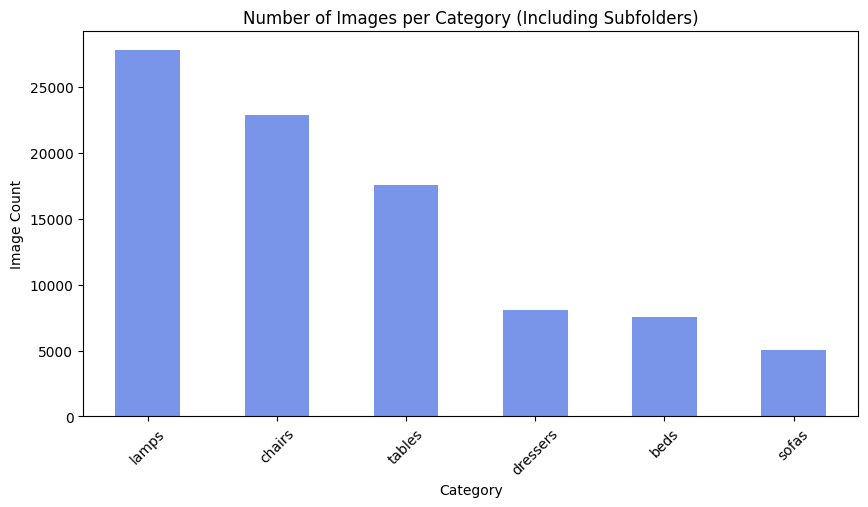

In [14]:
def count_images(category_path):
    """Counts all image files within a category, including subfolders."""
    count = 0
    for root, _, files in os.walk(category_path):
        count += sum(1 for file in files if file.lower().endswith(('.jpg', '.png', '.jpeg')))
    return count

# Count images for each category
category_counts = {category: count_images(os.path.join(dataset_path, category)) for category in categories}

# Convert to DataFrame
df = pd.DataFrame.from_dict(category_counts, orient="index", columns=["Image Count"])
df.sort_values("Image Count", ascending=False, inplace=True)

# Plot category distribution
plt.figure(figsize=(10, 5))
df["Image Count"].plot(kind="bar", color="royalblue", alpha=0.7)
plt.title("Number of Images per Category (Including Subfolders)")
plt.xlabel("Category")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.show()

There is a slight decrease in classes with high amount.

### Split the dataset to train - validation - testing sets with the ratio: 70% - 15% - 15%

In [15]:
from sklearn.model_selection import train_test_split

# Create the split folder structure
split_path = 'Task1_Data_Split'
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(split_path, split, category), exist_ok=True)

# Split and copy images
for category in categories:
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)

    # Split into train (70%), val (15%), and test (15%)
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

    # Copy images to the respective folders
    for image in train_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(split_path, 'train', category, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(split_path, 'val', category, image)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(split_path, 'test', category, image)
        shutil.copy(src, dst)

### Check the distribution of the training

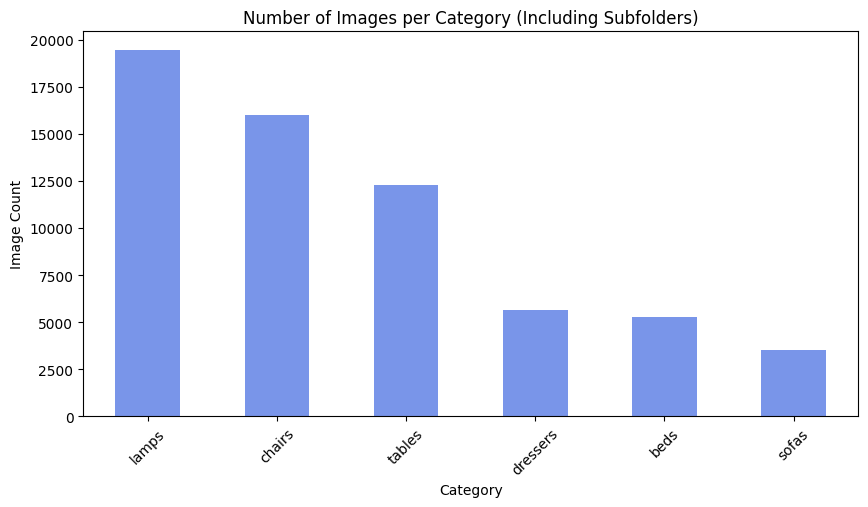

In [16]:
train_data_path = "/content/" + split_path + "/train"

def count_images(category_path):
    """Counts all image files within a category, including subfolders."""
    count = 0
    for root, _, files in os.walk(category_path):
        count += sum(1 for file in files if file.lower().endswith(('.jpg', '.png', '.jpeg')))
    return count

# Count images for each category
category_counts = {category: count_images(os.path.join(train_data_path, category)) for category in categories}

# Convert to DataFrame
df = pd.DataFrame.from_dict(category_counts, orient="index", columns=["Image Count"])
df.sort_values("Image Count", ascending=False, inplace=True)

# Plot category distribution
plt.figure(figsize=(10, 5))
df["Image Count"].plot(kind="bar", color="royalblue", alpha=0.7)
plt.title("Number of Images per Category (Including Subfolders)")
plt.xlabel("Category")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.show()

Since it is imbalance, we need to apply oversampling to smaller categories to raise the balance.

### Find the 4 lowest categories (We can infer this from the plot)

In [17]:
from sklearn.utils import resample
import numpy as np

# Example: Oversample minority classes
df = pd.DataFrame.from_dict(category_counts, orient="index", columns=["Image Count"])
df = df.sort_values("Image Count", ascending=True)
minority_classes = df[:4].index.to_numpy()  # Convert index to NumPy array
print(minority_classes)

['sofas' 'beds' 'dressers' 'tables']


### Oversample data in these four categories up to the mean of the whole dataset.

In [18]:
import math

# Step 1: Count images in each class
class_counts = {}
for class_name in os.listdir(train_data_path):
    class_path = os.path.join(train_data_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Step 2: Find the majority class count
mean_samples = math.ceil(sum(class_counts.values()) / len(class_counts))
print(f"Majority class has {mean_samples} samples")

# Step 3: Oversample minority classes
for class_name in minority_classes:
    class_path = os.path.join(train_data_path, class_name)
    images = os.listdir(class_path)

    if len(images) < mean_samples:
        # Compute how many images we need to add
        num_samples_needed = mean_samples - len(images)

        # Resample with replacement to get the needed images
        new_images = resample(images, replace=True, n_samples=num_samples_needed, random_state=42)

        # Duplicate the images
        for i, img in enumerate(new_images):
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(class_path, f"aug_{i}_{img}")  # Rename duplicate to avoid conflicts
            shutil.copy(src_path, dst_path)

        print(f"Oversampled {class_name}: Added {num_samples_needed} images")


Majority class has 10365 samples
Oversampled sofas: Added 6818 images
Oversampled beds: Added 5098 images
Oversampled dressers: Added 4728 images


### Plot again to see the difference

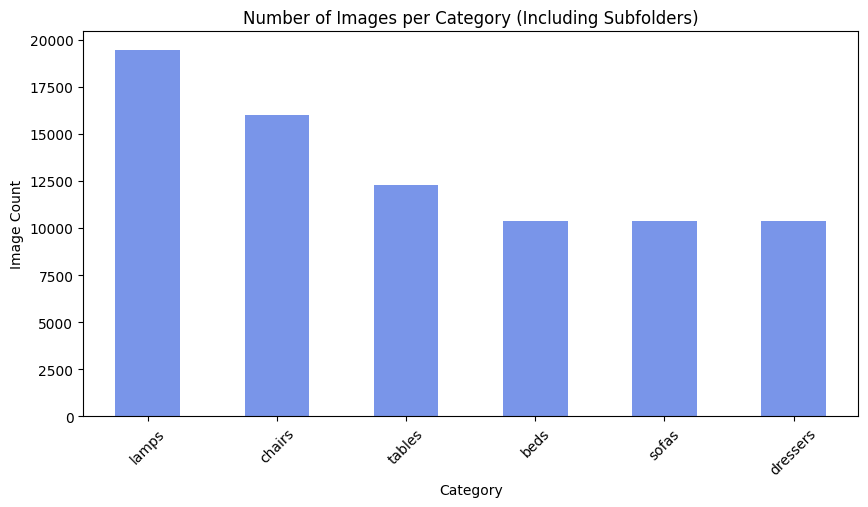

In [19]:
train_data_path = "/content/" + split_path + "/train"

def count_images(category_path):
    """Counts all image files within a category, including subfolders."""
    count = 0
    for root, _, files in os.walk(category_path):
        count += sum(1 for file in files if file.lower().endswith(('.jpg', '.png', '.jpeg')))
    return count

# Count images for each category
category_counts = {category: count_images(os.path.join(train_data_path, category)) for category in categories}

# Convert to DataFrame
df = pd.DataFrame.from_dict(category_counts, orient="index", columns=["Image Count"])
df.sort_values("Image Count", ascending=False, inplace=True)

# Plot category distribution
plt.figure(figsize=(10, 5))
df["Image Count"].plot(kind="bar", color="royalblue", alpha=0.7)
plt.title("Number of Images per Category (Including Subfolders)")
plt.xlabel("Category")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.show()

Now the dataset is more balance. You can raise the number of samples each class as you like, but too high may lead to overfitting to some specific images.

### It's time to perform data augmentation as following:
In these generators, I set the batch sizes very high to utilize the huge RAM of A100 GPU of Google Colab, if you use a weaker GPU, please adjust the batch size accordingly. It should be around 32 for the train generator, and 64 for validation and test.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=15,  # Rotate images by ±15 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10%
    height_shift_range=0.1,  # Shift images vertically by up to 10%
    shear_range=0.1,  # Shear images by up to 10%
    zoom_range=0.1,  # Zoom in/out by up to 10%
    horizontal_flip=True,  # Flip images horizontally
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'  # Fill missing pixels after transformations
)

# Load dataset with augmentation
train_generator = train_datagen.flow_from_directory(
    directory='Task1_Data_Split/train',
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=256,
    class_mode='categorical'  # Use 'binary' for binary classification
)

# For validation and test sets, use only rescaling (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_test_datagen.flow_from_directory(
    directory='Task1_Data_Split/val',
    target_size=(224, 224),
    batch_size=512,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    directory='Task1_Data_Split/test',
    target_size=(224, 224),
    batch_size=512,
    class_mode='categorical'
)

Found 78828 images belonging to 6 classes.
Found 13325 images belonging to 6 classes.
Found 13328 images belonging to 6 classes.


### Install the keras-tuner to perform model tuning

In [21]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.0 MB/s eta 0:00:00


### This is my model architecture:
It is a Sequential model contains:
- 3 pairs of Conv2D and MaxPooling2D layers, which increases in the filter numbers to capture every pattern of the data.
- A Flatten layer afterward.
- A fully-connected Dense layer.
- A Dropout layer next to reduce overfitting (as we have oversampled images)
- The output layer with 'softmax' activation function and 6 units to perform our categorizing task.

I also set up an early stopping callback to reduce training time.

For the tuner, I chose Hyperband for faster tuning, and Hyperband is also suitable for Conv2D based models with increasing units.

Use the summary() function to show all hyperparameters need tuning.

In [3]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Define the model-building function
def build_model(hp):
    model = Sequential()

    # Convolutional layers with tunable filter size
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3,3), activation='relu', padding='same'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=128, max_value=512, step=128),
        kernel_size=(3,3), activation='relu', padding='same'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully connected layers with tunable units
    model.add(Dense(
        units=hp.Int('dense1_units', min_value=128, max_value=1024, step=128),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(6, activation='softmax'))  # 6 classes (furniture categories)

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=3, restore_best_weights=True
)

# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,  # Train models for 10 epochs before elimination
    factor=3,  # Reduces bad models quickly
    directory='kt_hyperband',
    project_name='furniture_tuning'
)


# Display the search space
tuner.search_space_summary()




Reloading Tuner from kt_hyperband/furniture_tuning/tuner0.json
Search space summary
Default search space size: 6
conv1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
conv3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dense1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 128, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}


### Now start searching

In [27]:
# Run the hyperparameter search
tuner.search(
    train_generator,  # Training dataset
    validation_data=val_generator,  # Validation dataset
    epochs=10,
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparam eters: {best_hps.values}")


Trial 11 Complete [00h 00m 26s]

Best val_accuracy So Far: 0.8944090008735657
Total elapsed time: 04h 48m 17s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
128               |32                |conv1_filters
64                |128               |conv2_filters
384               |512               |conv3_filters
256               |640               |dense1_units
0.2               |0.3               |dropout_rate
0.0001            |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ke

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-27-7c472c452aa5>", line 2, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.10 = (f32[256,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,112,112]{3,2,1,0} %reduce-window.3, f32[64,128,3,3]{3,2,1,0} %bitcast.3129, f32[64]{0} %arg5.6), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1660944384 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_115511]


Since the searching process runs 11 trials and got disturbed, I had to set the hyperparameters manually according to best searched ones. Alternatively, you can you use the "best_hps = tuner.get_best_hyperparameters" to get them automatically after searching.

In [1]:
from keras_tuner import HyperParameters

# Manually define the best hyperparameters
best_hps = HyperParameters()
best_hps.Fixed('conv1_filters', 32)
best_hps.Fixed('conv2_filters', 128)
best_hps.Fixed('conv3_filters', 512)
best_hps.Fixed('dense1_units', 640)
best_hps.Fixed('dropout_rate', 0.3)
best_hps.Fixed('learning_rate', 0.001)


0.001

Now train the model again with the best hyperparameters and save it. I chose to train with 15 epochs due to limited compute resources. You can train on a higher epoch numbers for better performance.

In [6]:
# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_generator, validation_data=val_generator, epochs=15)

# Save the best model
best_model.save("best_furniture_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 1036s 3s/step - accuracy: 0.5396 - loss: 2.3790 - val_accuracy: 0.8654 - val_loss: 0.4005
Epoch 2/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 980s 3s/step - accuracy: 0.8144 - loss: 0.5407 - val_accuracy: 0.8954 - val_loss: 0.3140
Epoch 3/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 986s 3s/step - accuracy: 0.8631 - loss: 0.4061 - val_accuracy: 0.9096 - val_loss: 0.2692
Epoch 4/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 990s 3s/step - accuracy: 0.8819 - loss: 0.3484 - val_accuracy: 0.9171 - val_loss: 0.2469
Epoch 5/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 984s 3s/step - accuracy: 0.8932 - loss: 0.3142 - val_accuracy: 0.9256 - val_loss: 0.2236
Epoch 6/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 985s 3s/step - accuracy: 0.9003 - loss: 0.2928 - val_accuracy: 0.9313 - val_loss: 0.2120
Epoch 7/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 987s 3s/step - accuracy: 0.9109 - loss: 0.2688 - val_accuracy: 0.9352 - val_loss: 0.1945
Epoch 8/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 989s 3s/step - accuracy: 0.9141 - loss: 0.2558 - val_acc

In [9]:
from tensorflow import keras

best_model.save("best_furniture_model.keras")

### Evaluate the model with the testing set
Our model provides nearly 95% accuracy and a quite low loss. While this number is slightly smaller than the previous one, but let's check how it performs with various images with backgrounds.

In [10]:
best_model.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 872ms/step - accuracy: 0.9485 - loss: 0.1592


[0.16459503769874573, 0.9476290345191956]

### Set up the preprocess function to test with strange images

In [15]:
import numpy as np
import tensorflow as tf

def preprocess_image(image_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB

    # Resize to (224, 224)
    image = tf.image.resize(image, (224, 224))

    # Normalize to [0, 1] range
    image = image / 255.0

    # Add batch dimension
    image = np.expand_dims(image, axis=0)  # Shape becomes (1, 224, 224, 3)

    return image


### Load the model again and start predicting.

My predictions have shown that this model performs very well with various backgrounded images, so we have mitigated the issue of Part 1.

You can add your own images to make predictions.

Here's the model link: https://drive.google.com/file/d/1Jqgsc8NznuETPFeSpH3cjXVO-Nxex915/view?usp=sharing

In [23]:
import keras
best_model = keras.saving.load_model("/content/best_furniture_model.h5")

# Load and preprocess the image
image_path = "/content/image12.jpg"  # Change to your image path
image = preprocess_image(image_path)

# Predict
predictions = best_model.predict(image)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

# Print results
print(f"Predicted Class: {predicted_class}")

# Get the class indices from the train generator
class_indices = train_generator.class_indices

# Reverse the dictionary to map index → class label
class_labels = {v: k for k, v in class_indices.items()}

print(f"Predicted Category: {class_labels[predicted_class]}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Predicted Class: 3
Predicted Category: lamps


In [26]:
from google.colab import files
files.download('/content/best_furniture_model.h5')  # Downloads the model to your local device


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>